**Metodologia**

1. Sele√ß√£o de vari√°veis: Visando √† parcimonicidade do modelo, primeiro realizou-se uma sele√ß√£o de vari√°veis com base nos seguintes crit√©rios: (a) vari√°veis num√©ricas - coeficiente de varia√ß√£o e correla√ß√£o de pearson (b) entropia normalizada e informa√ß√£o m√∫tua normalizada. 

2. Amostragem estratificada: Para garantir efici√™ncia computacional, foi extra√≠da uma amostra estratificada do conjunto de dados. A estratifica√ß√£o utilizou a vari√°vel CO_MUNICIPIO_PROVA (c√≥digo do munic√≠pio de aplica√ß√£o da prova). 

3. Valida√ß√£o interna: A classe KPrototypeEvaluator foi usada para avaliar diferentes hiperparametros do algoritmo k-prototypes (n√∫mero de clusters e gamma), usando como m√©tricas TWSS, silhouette e √≠ndice de Dunn. Silhouette e Dunn foram calculados usando a matriz de dist√¢ncia calculada usando dist√¢ncia de Gower. 

4. Valida√ß√£o externa: Embora n√£o haja true labels para uma valida√ß√£o externa cl√°ssica, buscou-se avaliar a capacidade de generaliza√ß√£o. Cada algoritmo foi treinado com dados do Amazonas e seus r√≥tulos comparados aos obtidos em um modelo treinado com dados do Rio de Janeiro, utilizando o Adjusted Rand Index (ARI) e inspe√ß√£o visual.

5. Estabilidade e escalabilidade: A estabilidade foi medida por tr√™s experimentos, sempre com ARI:
(a) Seed ‚Äì impacto da semente aleat√≥ria;
(b) Cross-sample ‚Äì influ√™ncia da amostra espec√≠fica utilizada.
A escalabilidade foi avaliada pelo tempo de processamento em diferentes tamanhos de amostra.

6. Import√¢ncia de vari√°veis e interpretabilidade: Treinou-se uma √°rvore de decis√£o tendo o cluster como vari√°vel resposta, a fim de identificar caracter√≠sticas-chave de cada grupo. Tamb√©m se analisou a import√¢ncia das vari√°veis originais via permuta√ß√£o em random forest e, por fim, a signific√¢ncia das diferen√ßas entre clusters por ANOVA e qui-quadrado, complementada por medidas de efeito (Cohen‚Äôs d e Cramer‚Äôs V).

In [1]:
import sys
import os
import pandas as pd 

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.clustering.original_space_clustering import KPrototypesEvaluator, FeatureSelector

In [2]:
df = pd.read_csv(r'C:\Users\jaret\OneDrive\Documents\UFG\TCC\ENEM - final\data\MICRODADOS_RJ_clean_2023.csv')

**Sele√ß√£o de vari√°veis**

--- FeatureSelector Initialized ---
Detected 6 numerical columns: ['CO_MUNICIPIO_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
Detected 29 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 1.00% fraction...
Sampling complete. Active dataset reduced from 177828 to 1776 rows.

--- Starting Feature Analysis ---
Calculating Coefficient of Variation for numerical features...
Calculating Correlation Matrix for numerical features...
Calculating Normalized Entropy for categorical features...
Calculating Normalized Mutual Information for categorical features...


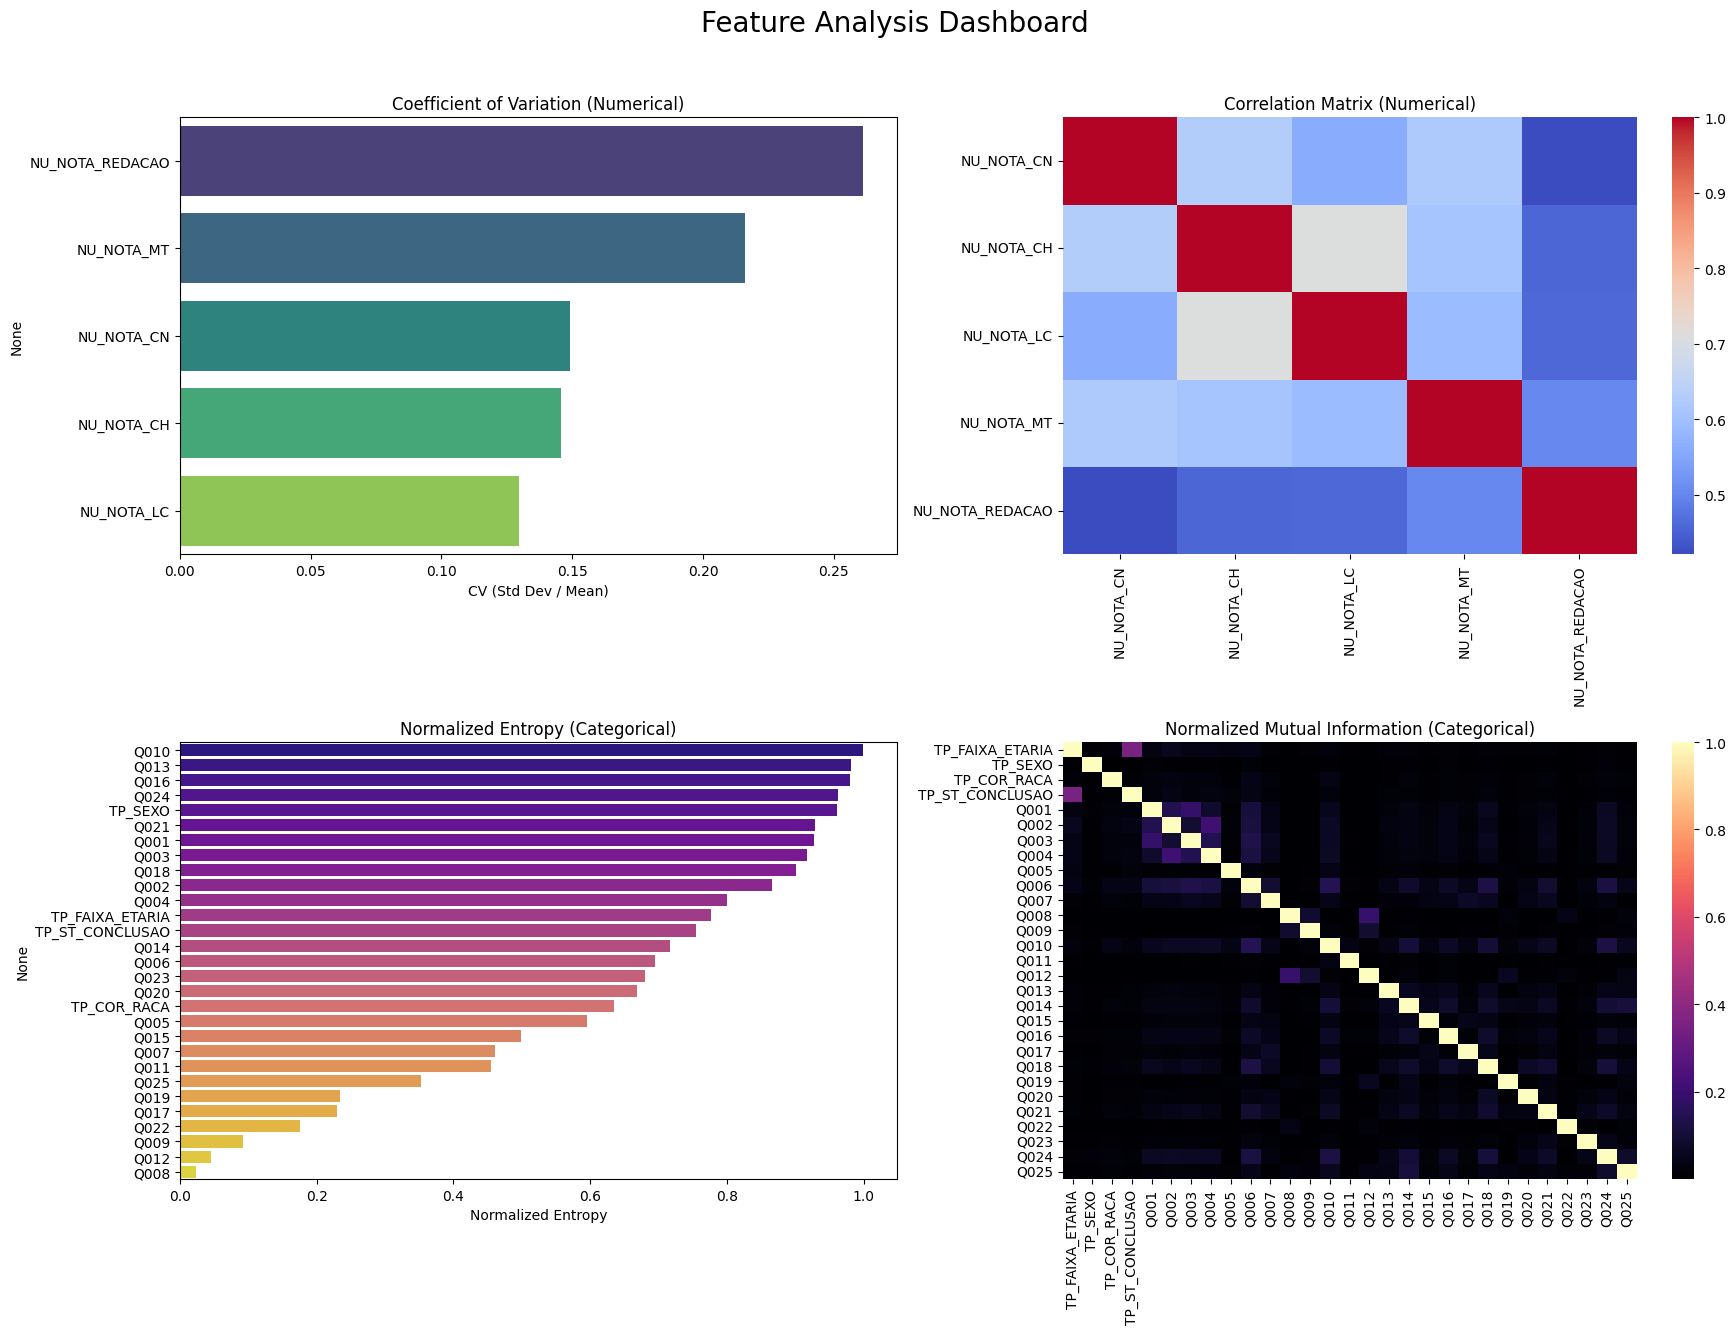

In [3]:
selector = FeatureSelector(df)
selector.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01
)
selector.analyze_features()

In [4]:
df_selected = selector.select_features(
    cv_threshold=0.2, 
    correlation_threshold=0.7, 
    entropy_threshold=0.7, 
    mutual_info_threshold=0.5
)
selected_features = df_selected.columns.tolist()
selected_features.append('CO_MUNICIPIO_PROVA')


--- Starting Feature Selection Process ---

Analyzing 5 numerical features...
Checking for Coefficient of Variation below 0.2...
  -> Found 3 low-CV columns to drop: ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
Checking for Pearson correlations above 0.7...
  -> No highly correlated column pairs found.

Checking for normalized entropy below 0.7...
  -> Found 15 low-entropy columns to drop: ['TP_COR_RACA', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q011', 'Q012', 'Q015', 'Q017', 'Q019', 'Q020', 'Q022', 'Q023', 'Q025']
Checking for normalized mutual information above 0.5...
  -> No high mutual information column pairs found.

Dropping a total of 18 unique columns: ['Q008', 'Q011', 'NU_NOTA_CH', 'Q012', 'Q017', 'Q006', 'NU_NOTA_CN', 'Q005', 'Q009', 'Q015', 'TP_COR_RACA', 'Q019', 'Q022', 'Q025', 'Q023', 'Q020', 'Q007', 'NU_NOTA_LC']
Feature selection complete.

--- Feature Selection Finished ---


**Inicia√ß√£o da inst√¢ncia da classe do avaliador dos modelos**

In [5]:
k_range = range(2,9)
evaluator = KPrototypesEvaluator(
    df=df[selected_features], 
    original_df_full=df,
    k_range=k_range, 
    gamma_list=[0.1, 0.5, 0.8, 1.0, 2.0, 4.0],
    random_state=42
)
evaluator.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01
)
evaluator.scale_numerical_features()

Full original dataframe loaded for statistical analysis.
Detected 3 numerical columns: ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'CO_MUNICIPIO_PROVA']
Detected 14 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q014', 'Q016', 'Q018', 'Q021', 'Q024']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 1.00% fraction...
Sampling complete. Active dataset reduced from 177828 to 1776 rows.
Scaling 2 numerical features...
Scaling complete. Active dataset has been updated.


TP_FAIXA_ETARIA    TP_SEXO  \
49534          17 anos  Masculino   
36740          17 anos   Feminino   
109614         18 anos  Masculino   
40550          18 anos   Feminino   
8599           19 anos   Feminino   
...                ...        ...   
12413          18 anos   Feminino   
109663         18 anos   Feminino   
155122         17 anos  Masculino   
120857         18 anos   Feminino   
60315          19 anos  Masculino   

                                          TP_ST_CONCLUSAO  NU_NOTA_MT  \
49534   Estou cursando e concluirei o Ensino M√©dio em ...    1.792239   
36740   Estou cursando e concluirei o Ensino M√©dio ap√≥...   -0.530709   
109614  Estou cursando e concluirei o Ensino M√©dio em ...    1.488379   
40550   Estou cursando e concluirei o Ensino M√©dio em ...   -1.758601   
8599                            J√° conclu√≠ o Ensino M√©dio   -0.658563   
...                                                   ...         ...   
12413   Estou cursando e concluirei o Ensino M√©dio em ...    0.536950   
109663                          J√° conclu√≠ o Ensino M√©dio    0.458079   
155122  Estou cursando e concluirei o Ensino M√©dio em ...    1.794730   
120857  Estou cursando e concluirei o Ensino M√©dio em ...    0.711296   
60315                           J√° conclu√≠ o Ensino M√©dio    0.718768   

        NU_NOTA_REDACAO              Q001              Q002  \
49534          0.811575  Faculdade ou p√≥s       EM completo   
36740          0.811575       EM completo  Faculdade ou p√≥s   
109614         0.115491       EM completo       EM completo   
40550          1.043603     EF incompleto     EF incompleto   
8599          -0.928634  Faculdade ou p√≥s  Faculdade ou p√≥s   
...                 ...               ...               ...   
12413         -1.392690       EM completo       EM completo   
109663         0.231505     EF incompleto  Faculdade ou p√≥s   
155122         1.043603  Faculdade ou p√≥s  Faculdade ou p√≥s   
120857         0.347519     EF incompleto       EM completo   
60315          0.811575     EF incompleto     EF incompleto   

                                                     Q003  \
49534   Grupo 4: t√©cnicos, supervisores, pequenos empr...   
36740               Grupo 3: oper√°rios / t√©cnicos manuais   
109614   Grupo 5: profiss√µes de n√≠vel superior / gestores   
40550                 Grupo 1: ocupa√ß√µes rurais / b√°sicos   
8599                                             N√£o sabe   
...                                                   ...   
12413                 Grupo 2: servi√ßos b√°sicos, com√©rcio   
109663              Grupo 3: oper√°rios / t√©cnicos manuais   
155122   Grupo 5: profiss√µes de n√≠vel superior / gestores   
120857              Grupo 3: oper√°rios / t√©cnicos manuais   
60315               Grupo 3: oper√°rios / t√©cnicos manuais   

                                                     Q004 Q010 Q013 Q014 Q016  \
49534                                            N√£o sabe  Sim  Sim  Sim  Sim   
36740   Grupo 4: t√©cnicos, supervisores, pequenos empr...  Sim  Sim  Sim  N√£o   
109614                                           N√£o sabe  Sim  Sim  Sim  N√£o   
40550                 Grupo 1: ocupa√ß√µes rurais / b√°sicos  N√£o  N√£o  Sim  N√£o   
8599    Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  N√£o  N√£o  N√£o   
...                                                   ...  ...  ...  ...  ...   
12413                 Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  Sim  Sim  Sim   
109663  Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  Sim  Sim  Sim   
155122   Grupo 5: profiss√µes de n√≠vel superior / gestores  Sim  N√£o  Sim  Sim   
120857  Grupo 4: t√©cnicos, supervisores, pequenos empr...  Sim  Sim  Sim  Sim   
60315                 Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  Sim  Sim  Sim   

       Q018 Q021 Q024  
49534   N√£o  N√£o  Sim  
36740   N√£o  N√£o  Sim  
109614  Sim  Sim  Sim  
40550   N√£o  N√£o  N√£o  
8599    N√£o  N√£o  S


Running K-Prototypes for k in [2, 3, 4, 5, 6, 7, 8] and gamma in [0.1, 0.5, 0.8, 1.0, 2.0, 4.0]...
Calculating Gower distance matrix for evaluation metrics...
Gower matrix calculation complete.
  - Testing k=2, gamma=0.10...
  - Testing k=3, gamma=0.10...
  - Testing k=4, gamma=0.10...
  - Testing k=5, gamma=0.10...
  - Testing k=6, gamma=0.10...
  - Testing k=7, gamma=0.10...
  - Testing k=8, gamma=0.10...
  - Testing k=2, gamma=0.50...
  - Testing k=3, gamma=0.50...
  - Testing k=4, gamma=0.50...
  - Testing k=5, gamma=0.50...
  - Testing k=6, gamma=0.50...
  - Testing k=7, gamma=0.50...
  - Testing k=8, gamma=0.50...
  - Testing k=2, gamma=0.80...
  - Testing k=3, gamma=0.80...
  - Testing k=4, gamma=0.80...
  - Testing k=5, gamma=0.80...
  - Testing k=6, gamma=0.80...
  - Testing k=7, gamma=0.80...
  - Testing k=8, gamma=0.80...
  - Testing k=2, gamma=1.00...
  - Testing k=3, gamma=1.00...
  - Testing k=4, gamma=1.00...
  - Testing k=5, gamma=1.00...
  - Testing k=6, gamma=1.00...

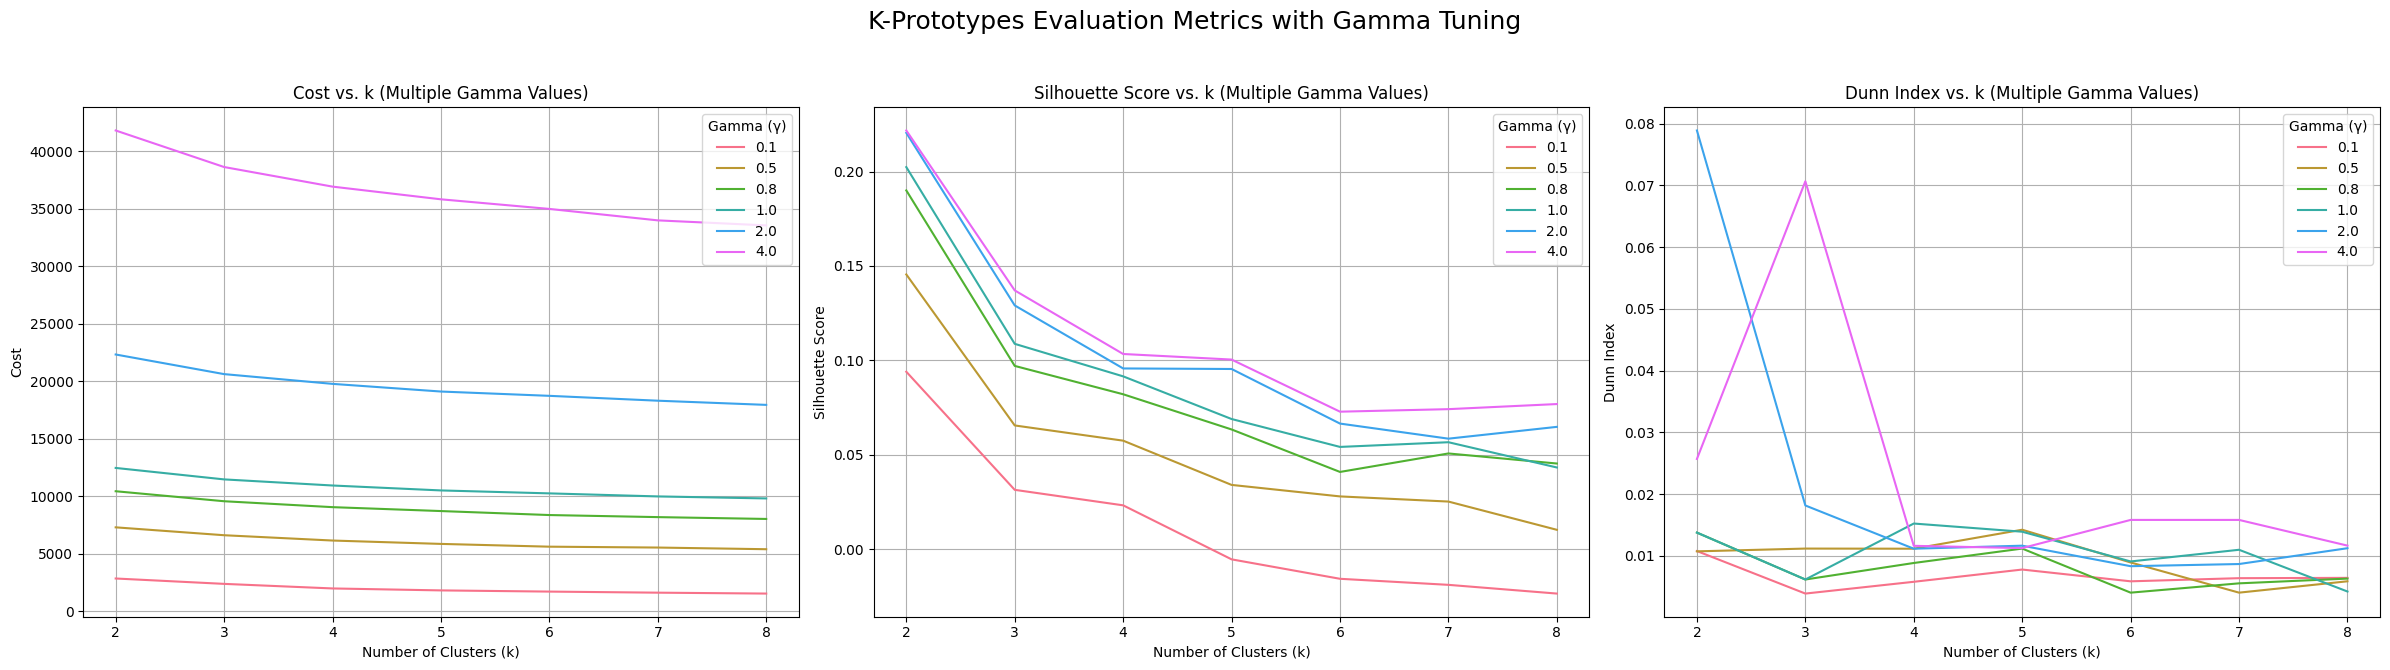

In [6]:
evaluator.run_and_evaluate()
evaluator.plot_evaluation_metrics()

In [7]:
k_prot_model = evaluator.run_final_model(optimal_k=2, optimal_gamma=2)
k_prot_model


Running final K-Prototypes model with k=2, gamma=2...
Final Gamma used: 2
Final model is trained and cluster labels are added to the DataFrame.


TP_FAIXA_ETARIA    TP_SEXO  \
49534          17 anos  Masculino   
36740          17 anos   Feminino   
109614         18 anos  Masculino   
40550          18 anos   Feminino   
8599           19 anos   Feminino   
...                ...        ...   
12413          18 anos   Feminino   
109663         18 anos   Feminino   
155122         17 anos  Masculino   
120857         18 anos   Feminino   
60315          19 anos  Masculino   

                                          TP_ST_CONCLUSAO  NU_NOTA_MT  \
49534   Estou cursando e concluirei o Ensino M√©dio em ...    1.792239   
36740   Estou cursando e concluirei o Ensino M√©dio ap√≥...   -0.530709   
109614  Estou cursando e concluirei o Ensino M√©dio em ...    1.488379   
40550   Estou cursando e concluirei o Ensino M√©dio em ...   -1.758601   
8599                            J√° conclu√≠ o Ensino M√©dio   -0.658563   
...                                                   ...         ...   
12413   Estou cursando e concluirei o Ensino M√©dio em ...    0.536950   
109663                          J√° conclu√≠ o Ensino M√©dio    0.458079   
155122  Estou cursando e concluirei o Ensino M√©dio em ...    1.794730   
120857  Estou cursando e concluirei o Ensino M√©dio em ...    0.711296   
60315                           J√° conclu√≠ o Ensino M√©dio    0.718768   

        NU_NOTA_REDACAO              Q001              Q002  \
49534          0.811575  Faculdade ou p√≥s       EM completo   
36740          0.811575       EM completo  Faculdade ou p√≥s   
109614         0.115491       EM completo       EM completo   
40550          1.043603     EF incompleto     EF incompleto   
8599          -0.928634  Faculdade ou p√≥s  Faculdade ou p√≥s   
...                 ...               ...               ...   
12413         -1.392690       EM completo       EM completo   
109663         0.231505     EF incompleto  Faculdade ou p√≥s   
155122         1.043603  Faculdade ou p√≥s  Faculdade ou p√≥s   
120857         0.347519     EF incompleto       EM completo   
60315          0.811575     EF incompleto     EF incompleto   

                                                     Q003  \
49534   Grupo 4: t√©cnicos, supervisores, pequenos empr...   
36740               Grupo 3: oper√°rios / t√©cnicos manuais   
109614   Grupo 5: profiss√µes de n√≠vel superior / gestores   
40550                 Grupo 1: ocupa√ß√µes rurais / b√°sicos   
8599                                             N√£o sabe   
...                                                   ...   
12413                 Grupo 2: servi√ßos b√°sicos, com√©rcio   
109663              Grupo 3: oper√°rios / t√©cnicos manuais   
155122   Grupo 5: profiss√µes de n√≠vel superior / gestores   
120857              Grupo 3: oper√°rios / t√©cnicos manuais   
60315               Grupo 3: oper√°rios / t√©cnicos manuais   

                                                     Q004 Q010 Q013 Q014 Q016  \
49534                                            N√£o sabe  Sim  Sim  Sim  Sim   
36740   Grupo 4: t√©cnicos, supervisores, pequenos empr...  Sim  Sim  Sim  N√£o   
109614                                           N√£o sabe  Sim  Sim  Sim  N√£o   
40550                 Grupo 1: ocupa√ß√µes rurais / b√°sicos  N√£o  N√£o  Sim  N√£o   
8599    Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  N√£o  N√£o  N√£o   
...                                                   ...  ...  ...  ...  ...   
12413                 Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  Sim  Sim  Sim   
109663  Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  Sim  Sim  Sim   
155122   Grupo 5: profiss√µes de n√≠vel superior / gestores  Sim  N√£o  Sim  Sim   
120857  Grupo 4: t√©cnicos, supervisores, pequenos empr...  Sim  Sim  Sim  Sim   
60315                 Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  Sim  Sim  Sim   

       Q018 Q021 Q024  cluster_kproto  
49534   N√£o  N√£o  Sim               0  
36740   N√£o  N√£o  Sim               0  
109614  Sim  Sim  Sim   


--- Generating Cluster Size Plot ---


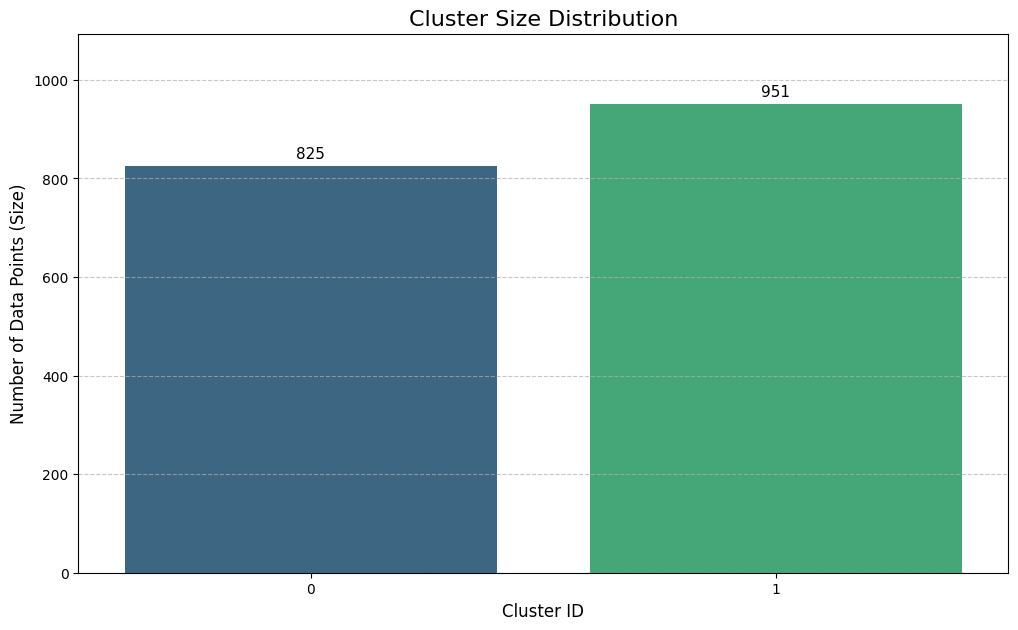

In [8]:
evaluator.plot_cluster_sizes()


--- Generating 2D Cluster Plot using FAMD on all features ---
Using the pre-scaled dataframe for FAMD.
FAMD components generated. Plotting now...


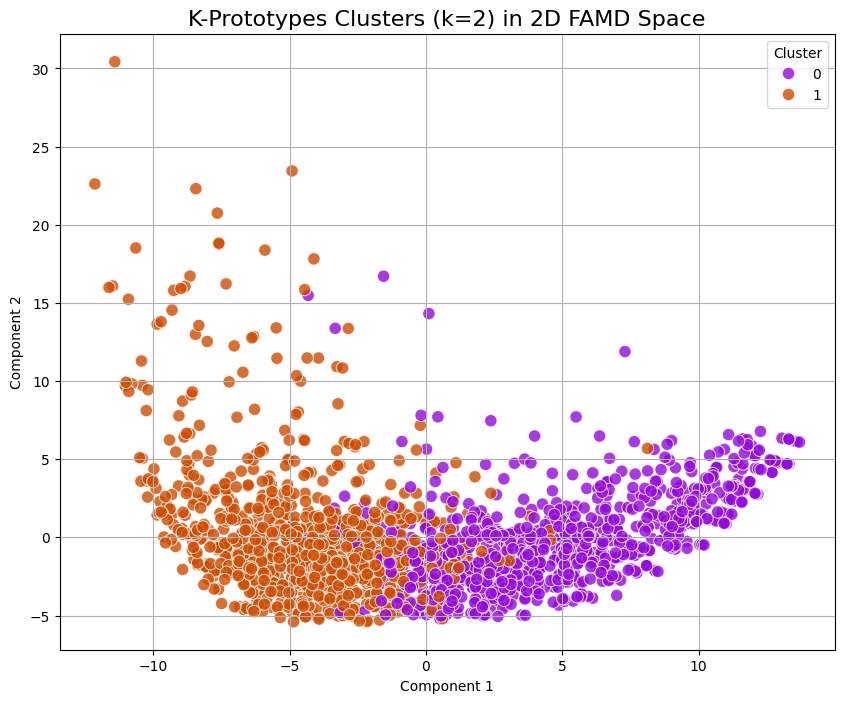

In [9]:
evaluator.plot_clusters_2d()

**Avalia√ß√£o de validade externa**

In [10]:
df_am = pd.read_csv(r'C:\Users\jaret\OneDrive\Documents\UFG\TCC\ENEM - final\data\MICRODADOS_AM_clean_2023.csv')
df_am = df_am.loc[:, selected_features]

In [11]:
k_range = range(2,9)
evaluator_am = KPrototypesEvaluator(
    df=df_am, 
    k_range=k_range, 
    random_state=42
)
evaluator_am.stratified_sample(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.05
)
evaluator_am.scale_numerical_features()
evaluator_am.run_final_model(optimal_k=2, optimal_gamma=2)

Assuming input dataframe contains all features for statistical analysis.
Detected 3 numerical columns: ['NU_NOTA_MT', 'NU_NOTA_REDACAO', 'CO_MUNICIPIO_PROVA']
Detected 14 categorical columns: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q014', 'Q016', 'Q018', 'Q021', 'Q024']
Performing stratified sampling on 'CO_MUNICIPIO_PROVA' with a 5.00% fraction...
Sampling complete. Active dataset reduced from 44720 to 2237 rows.
Scaling 2 numerical features...
Scaling complete. Active dataset has been updated.

Running final K-Prototypes model with k=2, gamma=2...
Final Gamma used: 2
Final model is trained and cluster labels are added to the DataFrame.


TP_FAIXA_ETARIA    TP_SEXO  \
27004         17 anos   Feminino   
12953         22 anos  Masculino   
28689         18 anos   Feminino   
36259         17 anos  Masculino   
21852         17 anos   Feminino   
...               ...        ...   
30642         17 anos  Masculino   
21507         18 anos   Feminino   
43086         17 anos   Feminino   
8854          17 anos  Masculino   
39881         18 anos   Feminino   

                                         TP_ST_CONCLUSAO  NU_NOTA_MT  \
27004  Estou cursando e concluirei o Ensino M√©dio em ...   -1.233048   
12953                          J√° conclu√≠ o Ensino M√©dio   -0.181983   
28689  Estou cursando e concluirei o Ensino M√©dio em ...    0.276335   
36259  Estou cursando e concluirei o Ensino M√©dio em ...    0.430612   
21852  Estou cursando e concluirei o Ensino M√©dio em ...   -0.836079   
...                                                  ...         ...   
30642  Estou cursando e concluirei o Ensino M√©dio em ...    0.290771   
21507  Estou cursando e concluirei o Ensino M√©dio em ...   -0.041240   
43086                          J√° conclu√≠ o Ensino M√©dio   -0.412947   
8854   Estou cursando e concluirei o Ensino M√©dio em ...   -0.947952   
39881  Estou cursando e concluirei o Ensino M√©dio em ...   -0.494145   

       NU_NOTA_REDACAO              Q001              Q002  \
27004        -0.419925       EF completo       EM completo   
12953         1.423429     EF incompleto     EF incompleto   
28689         0.071636       EF completo       EF completo   
36259        -0.419925  Faculdade ou p√≥s       EM completo   
21852        -1.894609     EF incompleto     EF incompleto   
...                ...               ...               ...   
30642        -1.034377       EM completo       EM completo   
21507        -0.788596     EF incompleto     EF incompleto   
43086         0.071636       EF completo  Faculdade ou p√≥s   
8854          0.071636  Faculdade ou p√≥s  Faculdade ou p√≥s   
39881        -1.034377     EF incompleto     EF incompleto   

                                                    Q003  \
27004                Grupo 1: ocupa√ß√µes rurais / b√°sicos   
12953                Grupo 1: ocupa√ß√µes rurais / b√°sicos   
28689                Grupo 1: ocupa√ß√µes rurais / b√°sicos   
36259  Grupo 4: t√©cnicos, supervisores, pequenos empr...   
21852                Grupo 1: ocupa√ß√µes rurais / b√°sicos   
...                                                  ...   
30642              Grupo 3: oper√°rios / t√©cnicos manuais   
21507                Grupo 1: ocupa√ß√µes rurais / b√°sicos   
43086                Grupo 1: ocupa√ß√µes rurais / b√°sicos   
8854   Grupo 4: t√©cnicos, supervisores, pequenos empr...   
39881                Grupo 2: servi√ßos b√°sicos, com√©rcio   

                                                    Q004 Q010 Q013 Q014 Q016  \
27004                Grupo 1: ocupa√ß√µes rurais / b√°sicos  N√£o  N√£o  N√£o  N√£o   
12953                Grupo 1: ocupa√ß√µes rurais / b√°sicos  N√£o  N√£o  Sim  N√£o   
28689                Grupo 1: ocupa√ß√µes rurais / b√°sicos  N√£o  N√£o  N√£o  N√£o   
36259  Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  Sim  Sim  Sim   
21852                Grupo 1: ocupa√ß√µes rurais / b√°sicos  N√£o  N√£o  Sim  N√£o   
...                                                  ...  ...  ...  ...  ...   
30642                Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  Sim  Sim  N√£o   
21507                Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  N√£o  N√£o  N√£o   
43086  Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  N√£o  Sim  N√£o   
8854   Grupo 4: t√©cnicos, supervisores, pequenos empr...  N√£o  N√£o  Sim  N√£o   
39881                Grupo 2: servi√ßos b√°sicos, com√©rcio  N√£o  N√£o  Sim  Sim   

      Q018 Q021 Q024  cluster_kproto  
27004  N√£o  N√£o  N√£o               0  
12953  N√£o  N√£o  N√£o               0  
28689  N√£o  N√£o  N√£o               0  
36259  N√£o  Sim  Si

In [12]:
evaluator.cross_predict_and_evaluate_kproto(
    target_evaluator=evaluator_am, 
    name_source="RJ", 
    name_target="AM"
)


--- Cross-Model Evaluation: 'RJ' Model -> 'AM' Data ---
Predicting labels on 'AM' data using 'RJ' model...
‚úÖ Adjusted Rand Score (ARI): 0.7021


0.702108561699766


--- Visualizing Cross-Prediction: 'RJ' Model vs. 'AM' Clusters ---
Using the target's pre-scaled data for FAMD visualization.
Reducing target data to 2D using FAMD...


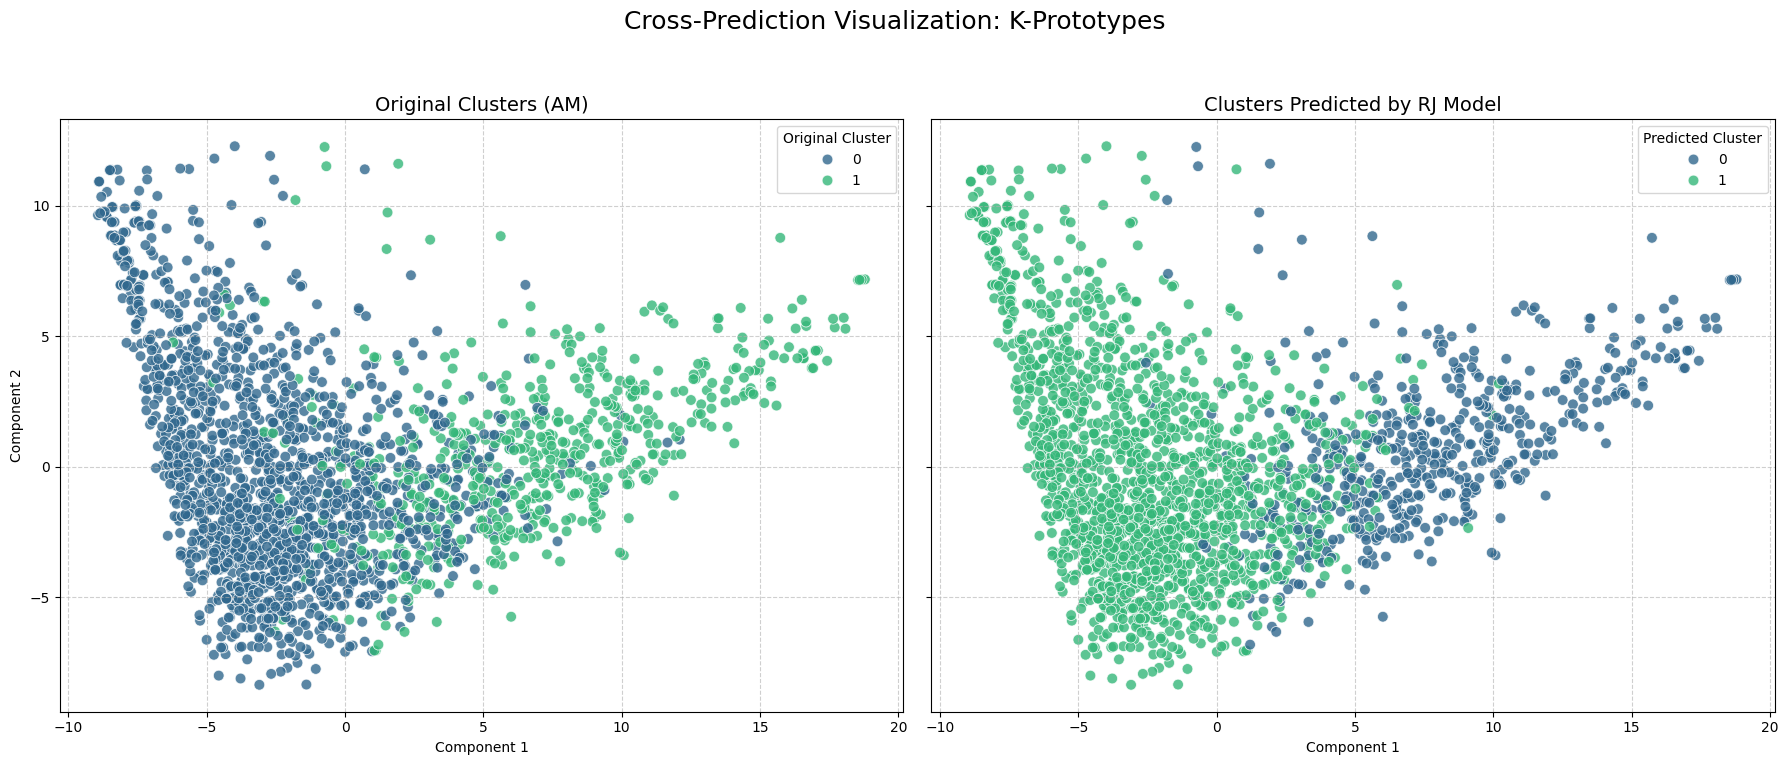

In [13]:
evaluator.plot_cross_prediction_comparison(
    target_evaluator=evaluator_am, 
    name_source="RJ", 
    name_target="AM"
)

**Avalia√ß√£o de estabilidade e escalabilidade**


--- Evaluating Cross-Sample Stability (50 iterations) ---
Calculating baseline clustering on the current active sample...
Using existing final model as baseline.
Beginning 50 cross-sample validation iterations...
  Iteration 10/50...
  Iteration 20/50...
  Iteration 30/50...
  Iteration 40/50...
  Iteration 50/50...

Cross-sample stability evaluation complete.
K-Prototypes (k=2) Stability: Mean ARI = 0.7907, Std Dev = 0.0658


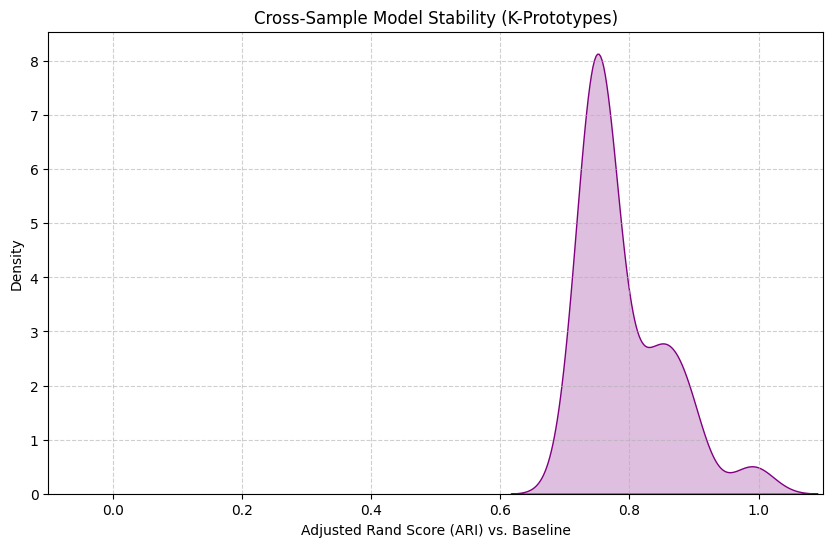

[1.0,
 0.7342444520380382,
 0.7517287607983697,
 0.7439371022969861,
 0.7419932681942806,
 0.7458827692118529,
 0.7517343071764612,
 0.8176103975625553,
 0.7419932681942806,
 0.8526250981862289,
 0.7439371022969861,
 0.7536839142533307,
 0.8904905580967388,
 0.7654737376686579,
 0.7381152805374542,
 0.8904903144519299,
 0.8196497507262641,
 0.8756699695160052,
 0.7674473199881845,
 0.7439364163051746,
 0.8526242282969566,
 0.7576040072296065,
 0.7654737376686579,
 0.7674473199881845,
 0.7074673044288704,
 0.7361782593038112,
 0.7576040072296065,
 0.8904900658336604,
 0.844317717952155,
 0.7993787796009733,
 0.7595674816818208,
 0.7419932681942806,
 0.9820526799042282,
 0.8401806849663439,
 0.7419946505874246,
 0.7458820942027026,
 0.7635020193839955,
 0.7419925594191698,
 0.7400540544102374,
 0.7576040072296065,
 0.7342467146269693,
 0.873562416409939,
 0.7595674816818208,
 0.7536846468435066,
 0.8926184500747543,
 0.765473082746239,
 0.7419939652503023,
 0.844317717952155,
 0.84018068

In [14]:
evaluator.evaluate_cross_sample_stability(
    strata_col="CO_MUNICIPIO_PROVA", 
    sample_frac=0.01, 
    optimal_k=2, 
    optimal_gamma=2)

In [15]:
seeds = [0, 51, 123, 2025, 9999]
evaluator.evaluate_stability_by_seed(
    optimal_k=2, 
    optimal_gamma=2, 
    random_seeds=seeds
)


--- Evaluating Stability by Seed for k=2 ---
K-Prototypes (k=2) Mean ARI vs. baseline seed: 1.0000 (Indicates sensitivity to initialization)


np.float64(1.0)


--- Evaluating Processing Time for k=2 ---
Timing for n=177 samples...
Timing for n=354 samples...
Timing for n=532 samples...
Timing for n=710 samples...
Timing for n=887 samples...
Timing for n=1065 samples...
Timing for n=1243 samples...
Timing for n=1420 samples...
Timing for n=1598 samples...
Timing for n=1776 samples...


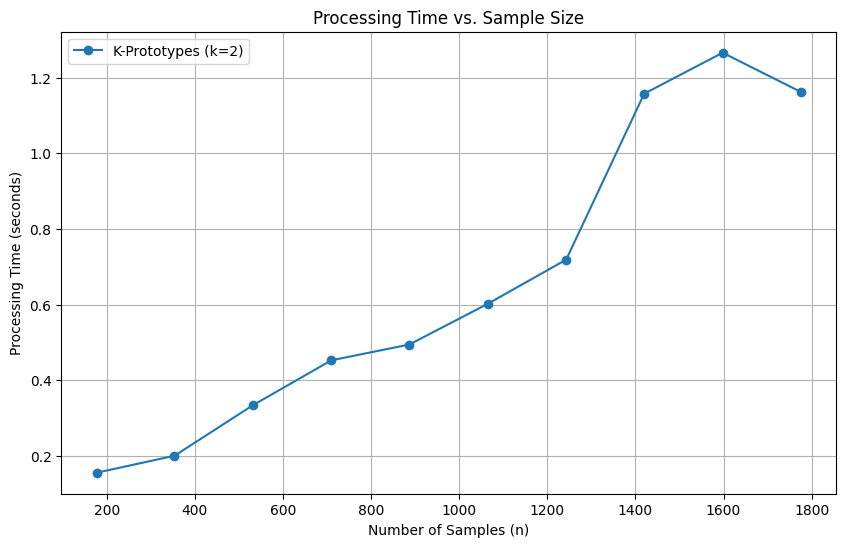

Number of Samples  Processing Time (s)
0                177             0.155261
1                354             0.200072
2                532             0.333843
3                710             0.452563
4                887             0.494318
5               1065             0.601961
6               1243             0.718783
7               1420             1.157649
8               1598             1.266026
9               1776             1.162107

In [16]:
evaluator.evaluate_processing_time(optimal_k=2, optimal_gamma=2)

**Import√¢ncia de vari√°veis e interpretabilidade**


--- Generating Decision Tree Visualization (max_depth=3) üå≥ ---
Found categorical features: ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ST_CONCLUSAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q010', 'Q013', 'Q014', 'Q016', 'Q018', 'Q021', 'Q024']. Applying One-Hot Encoding for the tree...


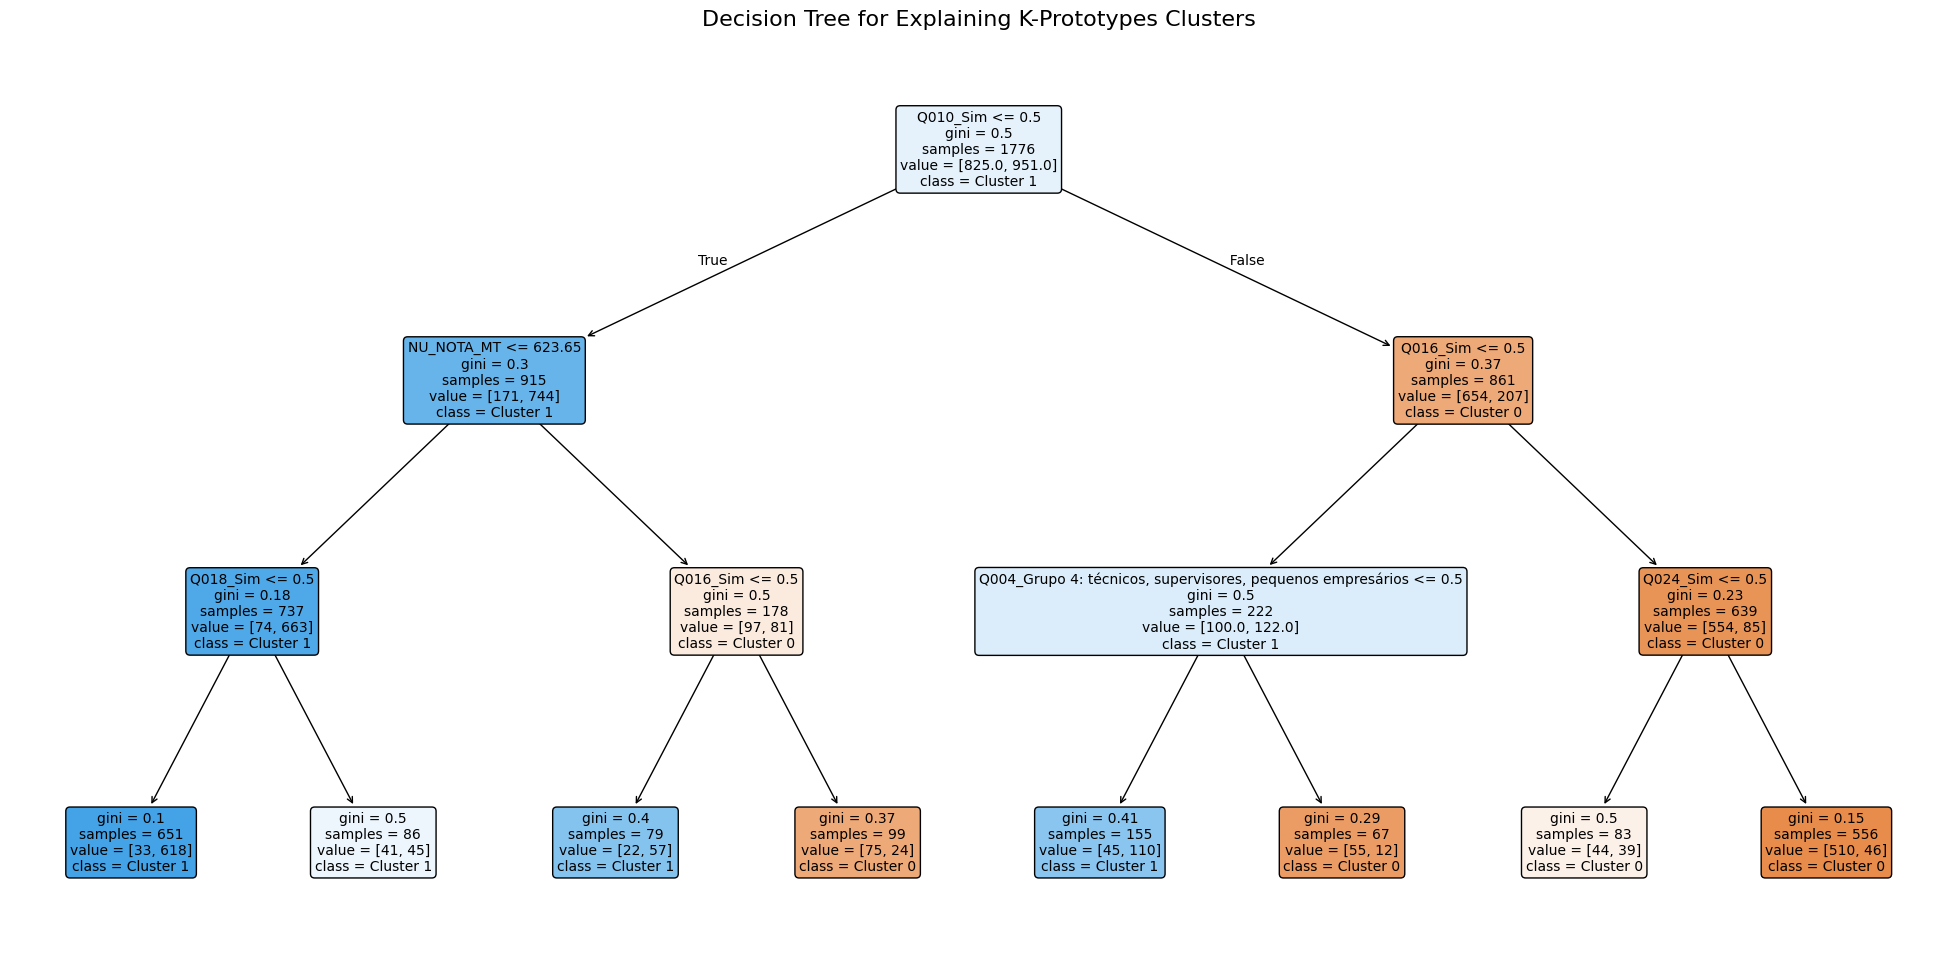

In [17]:
evaluator.plot_decision_tree_importance()


--- Calculating Permutation Importance for K-Prototypes ---
Training Random Forest surrogate model...
Calculating importance based on 'accuracy' drop...


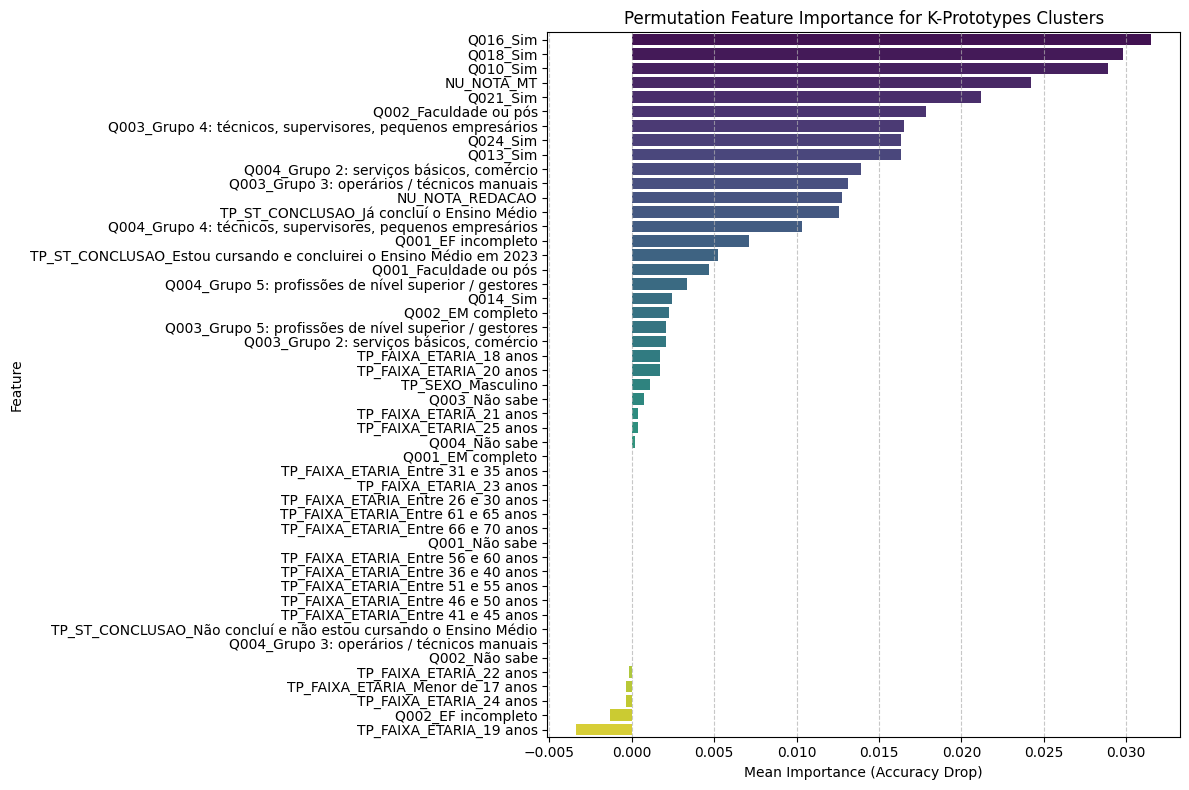

feature  importance_mean  \
45                                           Q016_Sim     3.151970e-02   
46                                           Q018_Sim     2.983114e-02   
42                                           Q010_Sim     2.889306e-02   
0                                          NU_NOTA_MT     2.420263e-02   
47                                           Q021_Sim     2.120075e-02   
30                              Q002_Faculdade ou p√≥s     1.782364e-02   
34  Q003_Grupo 4: t√©cnicos, supervisores, pequenos...     1.651032e-02   
48                                           Q024_Sim     1.632270e-02   
43                                           Q013_Sim     1.632270e-02   
37           Q004_Grupo 2: servi√ßos b√°sicos, com√©rcio     1.388368e-02   
33         Q003_Grupo 3: oper√°rios / t√©cnicos manuais     1.313321e-02   
1                                     NU_NOTA_REDACAO     1.275797e-02   
22          TP_ST_CONCLUSAO_J√° conclu√≠ o Ensino M√©dio     1.257036e-02   
39  Q004_Grupo 4: t√©cnicos, supervisores, pequenos...     1.031895e-02   
24                                 Q001_EF incompleto     7.129456e-03   
21  TP_ST_CONCLUSAO_Estou cursando e concluirei o ...     5.253283e-03   
26                              Q001_Faculdade ou p√≥s     4.690432e-03   
40  Q004_Grupo 5: profiss√µes de n√≠vel superior / g...     3.377111e-03   
44                                           Q014_Sim     2.439024e-03   
29                                   Q002_EM completo     2.251407e-03   
35  Q003_Grupo 5: profiss√µes de n√≠vel superior / g...     2.063790e-03   
32           Q003_Grupo 2: servi√ßos b√°sicos, com√©rcio     2.063790e-03   
2                             TP_FAIXA_ETARIA_18 anos     1.688555e-03   
4                             TP_FAIXA_ETARIA_20 anos     1.688555e-03   
20                                  TP_SEXO_Masculino     1.125704e-03   
36                                      Q003_N√£o sabe     7.504690e-04   
5                             TP_FAIXA_ETARIA_21 anos     3.752345e-04   
9                             TP_FAIXA_ETARIA_25 anos     3.752345e-04   
41                                      Q004_N√£o sabe     1.876173e-04   
25                                   Q001_EM completo     3.330669e-17   
11                 TP_FAIXA_ETARIA_Entre 31 e 35 anos     0.000000e+00   
7                             TP_FAIXA_ETARIA_23 anos     0.000000e+00   
10                 TP_FAIXA_ETARIA_Entre 26 e 30 anos     0.000000e+00   
17                 TP_FAIXA_ETARIA_Entre 61 e 65 anos     0.000000e+00   
18                 TP_FAIXA_ETARIA_Entre 66 e 70 anos     0.000000e+00   
27                                      Q001_N√£o sabe     0.000000e+00   
16                 TP_FAIXA_ETARIA_Entre 56 e 60 anos     0.000000e+00   
12                 TP_FAIXA_ETARIA_Entre 36 e 40 anos     0.000000e+00   
15                 TP_FAIXA_ETARIA_Entre 51 e 55 anos     0.000000e+00   
14                 TP_FAIXA_ETARIA_Entre 46 e 50 anos     0.000000e+00   
13                 TP_FAIXA_ETARIA_Entre 41 e 45 anos     0.000000e+00   
23  TP_ST_CONCLUSAO_N√£o conclu√≠ e n√£o estou cursan...     0.000000e+00   
38         Q004_Grupo 3: oper√°rios / t√©cnicos manuais     0.000000e+00   
31                                      Q002_N√£o sabe     0.000000e+00   
6                             TP_FAIXA_ETARIA_22 anos    -1.876173e-04   
19                   TP_FAIXA_ETARIA_Menor de 17 anos    -3.752345e-04   
8                             TP_FAIXA_ETARIA_24 anos    -3.752345e-04   
28                                 Q002_EF incompleto    -1.313321e-03   
3                             TP_FAIXA_ETARIA_19 anos    -3.377111e-03   

    importance_std  
45        0.005678  
46        0.006018  
42        0.008808  
0         0.007336  
47        0.006870  
30        0.004538  
34        0.005226  
48        0.006502  
43        0.002789  
37        0.003580  
33        0.001876  
1         0.004878  
22        0.002913  
39        0.004982  
24

In [18]:
evaluator.plot_permutation_importance()

In [19]:
anova_results, chi2_results = evaluator.calculate_cluster_statistics()


--- Calculating Cluster Statistics for K-Prototypes ---
Statistical analysis complete.


In [20]:
anova_results

F-statistic        P-value  Significant
Variable                                                   
CO_MUNICIPIO_PROVA     4.334611   3.748799e-02         True
NU_NOTA_CN           332.022446   3.867522e-68         True
NU_NOTA_CH           266.407057   6.620863e-56         True
NU_NOTA_LC           232.337712   2.153642e-49         True
NU_NOTA_MT           630.835175  2.325325e-119         True
NU_NOTA_REDACAO      399.196778   2.879224e-80         True

In [21]:
chi2_results

Chi-Square        P-value  Significant
Variable                                               
TP_FAIXA_ETARIA  228.507967   1.856950e-38         True
TP_SEXO           20.439230   6.155498e-06         True
TP_COR_RACA      134.868028   2.203364e-27         True
TP_ST_CONCLUSAO  161.128521   1.046124e-34         True
Q001             480.694198  1.002820e-102         True
Q002             529.739832  2.472442e-113         True
Q003             578.036066  1.124777e-122         True
Q004             580.314854  3.620663e-123         True
Q005              43.359388   8.714968e-09         True
Q006             658.201018  7.055239e-138         True
Q007              90.039027   2.335082e-21         True
Q008               0.129181   7.192826e-01        False
Q009               7.579874   5.902355e-03         True
Q010             582.600407  1.019627e-128         True
Q011              15.736546   7.280390e-05         True
Q012               6.082560   1.365228e-02         True
Q013             292.213248   1.638007e-65         True
Q014             239.574438   4.869647e-54         True
Q015              77.686132   1.207864e-18         True
Q016             391.774370   3.400924e-87         True
Q017              39.039126   4.153965e-10         True
Q018             447.863232   2.104446e-99         True
Q019              24.806416   6.338612e-07         True
Q020             110.659011   7.027618e-26         True
Q021             374.150894   2.335765e-83         True
Q022               1.649426   1.990370e-01        False
Q023              74.770914   5.286280e-18         True
Q024             517.339509  1.604611e-114         True
Q025              92.386570   7.129630e-22         True

In [22]:
cohens_d_results, cramers_v_results = evaluator.calculate_effect_sizes()


--- Calculating Effect Sizes for K-Prototypes ---
Effect size calculation complete.


In [23]:
cohens_d_results

Cohen's d
Variable           Comparison                   
CO_MUNICIPIO_PROVA Cluster 0.0 vs 1.0   0.099056
NU_NOTA_CN         Cluster 0.0 vs 1.0   0.866938
NU_NOTA_CH         Cluster 0.0 vs 1.0   0.776564
NU_NOTA_LC         Cluster 0.0 vs 1.0   0.725211
NU_NOTA_MT         Cluster 0.0 vs 1.0   1.194984
NU_NOTA_REDACAO    Cluster 0.0 vs 1.0   0.950600

In [24]:
cramers_v_results

Cram√©r's V
Variable                   
TP_FAIXA_ETARIA    0.358698
TP_SEXO            0.107278
TP_COR_RACA        0.275571
TP_ST_CONCLUSAO    0.301207
Q001               0.520251
Q002               0.546147
Q003               0.570500
Q004               0.571624
Q005               0.156250
Q006               0.608776
Q007               0.225161
Q008               0.008529
Q009               0.065330
Q010               0.572748
Q011               0.094131
Q012               0.058522
Q013               0.405629
Q014               0.367281
Q015               0.209146
Q016               0.469674
Q017               0.148262
Q018               0.502171
Q019               0.118185
Q020               0.249616
Q021               0.458989
Q022               0.030475
Q023               0.205185
Q024               0.539717
Q025               0.228078